The aim of this notebook is to evaluate the solute drag effect in a binary substitutional alloy using Cahn's solute drag model. The composition at steady state is evaluated by solving a second order linear differential equation. This profile is then used to calculate the drag pressure for a given velocity. Similar procedure is adopted for different velocities to obtain the variation of drag pressure with velocity.

The equation solved are:
Composition :

$$ D\frac{d^2c}{dx^2} + \frac{dc}{dx}(\frac{dD}{dx} + \frac{D}{kT}\frac{dE}{dx} + V) + \frac{c}{kT}(\frac{dD}{dx} \frac{dE}{dx} + D\frac{d^2E}{dx^2} = 0)$$

Solute drag:
$$ P_{sd} = \frac{1}{V_m} \int_{-\infty}^{\infty} (c - c_0)\frac{dE}{dx}dx $$

Diffusion is assumed to vary inside the interface i.e. high diffusion inside the boundary than the bulk, Energy barrier is assumed to be a sharp well with peak at the midpoint. 

In [123]:
import numpy as np
from scipy.sparse.linalg import spsolve as eigensolver
from scipy.sparse import csr_matrix

In [486]:
class SoluteDrag(object):
    """
    Defines an object to solve the composition 
    profile at steady state and solute drag force 
    for a given composition, diffusivity, energy profile.
    
    Parameters
    -----------
    composition : Initial bulk composition
    Energy : Interaction potential
    Diffusivity 
    Temperature

    """

    def __init__(self, nondimensionalize = True, **kwargs):
        
        if nondimensionalize:
            self.database = self.nondimensionalize( **kwargs)
        else :
            self.database = kwargs
        self.check_spacing() #Check the initialization of dx and npoints
        self.epeak = self.database['energy']
        self.vel = self.database['velocity']
        self.length = self.database['length']
        self.gbwidth = self.database['gb']
        self.npoints = self.database['Nseg'] + 1
        self.c0 = self.database['bulk_comp']
        self.dx = self.database['dx']
        
        self.ngbpoints = int(self.gbwidth//self.dx + 1)
        self.bidx = [self.npoints//2 - self.ngbpoints//2, self.npoints//2 + self.ngbpoints//2] ##Start and stop index of boundary points
        self.composition = np.ones(self.npoints)*self.c0
    
    def solve_composition(self):
        """
        Calculates the composition profile for the initialized domain
        Returns
        -------
        composition : np array containing 
                        composition at various nodes at steady state
        """
        ##For the matrix Ay" + By' + Cy = 0
        grad_D = np.gradient(self.diffusivity,self.dx)
        grad_E = np.gradient(self.interaction,self.dx)
        A = self.diffusivity
        B = (grad_D + self.diffusivity*grad_E + np.ones(self.diffusivity.shape)*self.vel)
        C = (grad_D*grad_E)
        
        
        
        # a1*c[k-1] + a2*c[k] + a3*c[k+1] = 0
        sqdx = self.dx**2
        #Boundary Condition 
        self.composition[0],self.composition[1] = self.c0,self.c0
        
        #solve
        self.composition[2:] = [(-1/(A[k-1]/sqdx + B[k-1]/(2.*self.dx)))*(self.composition[k-1]*(C[k-1] - 2*A[k-1]/sqdx) + self.composition[k-2]*(A[k-1]/sqdx - B[k-1]/(2.*self.dx))) for k in range(2,self.npoints)]
        #a1 = (A/sqdx - B/(2.*self.dx))
        #a2 = (-2*A/sqdx + C)
        #a3 = (A/sqdx + B/(2.*self.dx))
        
        #Matrix = np.diag(a1[2:-1],-1) + np.diag(a2[1:-1],0) + np.diag(a3[1:-2],1)
        
        #Matrix*Vec = c_vec
        #c_vec = np.zeros(len(Matrix[0]))
        
        #Boundary Condition
        #c_vec[0] = -a1[1]*self.c0
        #c_vec[-1] = -a3[-1]*self.c0
        
        #solver
        #comp_vec = eigensolver(csr_matrix(Matrix),c_vec)
        #return comp_vec
        
        
    
    def setup(self, param_array):
        """
        Setup the diffusivity, energy based on the input
        Params
        ------
        dict containing features to setup
        """ 
        for item in param_array:
            if self.database.get(item,False):
                param = self.database[item]
                if item == 'diff':
                    self.diffusivity = self.setup_diffusivity(param)
                    #print(self.diffusivity)
                if item == 'energy':
                    self.interaction = self.setup_energy(param)
                    #print(self.interaction)
    
    def setup_diffusivity(self, params):
        """
        Setup Diffusivity profile
        Params :
        A list containing [bulk_diffusivity, boundary difusivity]
        """
        dbulk, dboundary =  params[0], params[1]
        diff_array = np.ones(self.npoints)*dbulk
        diff_array[self.bidx[0]:self.npoints // 2] += np.arange(self.ngbpoints//2
                                                                    ,dtype = np.float)*(dboundary - dbulk)/(self.ngbpoints//2)
        diff_array[self.npoints // 2 : self.bidx[1]] += np.arange(self.ngbpoints//2 
                                                                       ,dtype = np.float
                                                                 )*(-dboundary + dbulk
                                                                   )/(self.ngbpoints//2) +np.ones(self.ngbpoints//2,dtype 
                                                                                                  = np.float)*(dboundary-dbulk)
        return diff_array
    
    def setup_energy(self, params):
        """
        Setup Interaction Profile
        """
        if len(params) == 1:
            estart = 0.0
            epeak = params[0]
        else :
            estart = params[0]
            epeak = params[1]
        energy_array = np.ones(self.npoints)*estart
        energy_array[self.bidx[0]:self.npoints // 2] += np.arange(self.ngbpoints//2
                                                                    ,dtype = np.float)*(epeak - estart)/(self.ngbpoints//2)
        energy_array[self.npoints // 2 : self.bidx[1]:] += np.arange(self.ngbpoints//2 
                                                                       ,dtype = np.float)*(
            - epeak + estart)/(self.ngbpoints//2) + np.ones(self.ngbpoints//2,dtype 
                                                           = np.float)*(epeak-estart)
        return energy_array
    
    
    def nondimensionalize(self, **kwargs):
        """
        Use non-dimensional parameters for solving the equation
        """
        nd_diff = kwargs['diff'][0] # Bulk Diffusivity
        nd_length = 1.E-11 #General length scale of interface
        nd_vel = nd_diff/nd_length # From the equation of flux
        
        print("Scaling Factors:")
        print("-------------------")
        print("Diffusivity = {}".format(nd_diff))
        print("Length = {}".format(nd_length))
        print("Velocity = {}".format(nd_vel))
        print("-------------------")
        #Substitute the values in dict
        if kwargs.get('diff',False):
            kwargs['diff'] = [x/nd_diff for x in kwargs['diff']]
        for item in ['length','gb','dx']:
            if kwargs.get(item,False):
                kwargs[item] /= nd_length
        if kwargs.get('velocity',False):   
            kwargs['velocity'] /= nd_vel
        
        #Fill in Npoints and/or dx, if not available
        
                    
        print(kwargs)
        return kwargs
    
    def check_spacing(self):
        Npoints,dx = self.database.get('Nseg',None), self.database.get('dx',None)
        if Npoints is None:
            self.database['Nseg'] = int(self.database['length']/kwargs['dx'])
        elif dx is None:
            self.database['dx'] = self.database['length']/self.database['Nseg']
        else:
            if all(v is None for v in [dx,Npoints]):
                printf("Need atleast dx or Npoints")
            else:
                #Nsegments has the priority
                self.database['dx'] = self.database['length']/self.database['Nseg']
        
    def solute_drag():
        """
        Evaluate the drag pressure based on the model chosen
        """
        pass
    

# Initialize 

In [487]:
bulk_comp = 0.01 # In atomic percent
length = 1.E-8 # in nanometers
#dx = 5.E-12 # Grid Spacing
Nseg = 1000 #Number of segments
gb_width = 3.E-10 # in nanometers
vel = 0.1

bulk_diff = 1E-11
boundary_diff = 1E-11
E0 = -2.

In [500]:
#non-dimensionalized parameters
bulk_comp = 0.01 # In atomic percent
length = 1000. 
dx = 1 # Grid Spacing
#Nseg = 1000 
gb_width = 300. 
vel = 10.

bulk_diff = 1.
boundary_diff = 1.
E0 = -2.

In [501]:
dict_params = {'diff':[bulk_diff, boundary_diff],
               'energy':[E0], 
               'velocity':vel,
               'length':length,
               'gb':gb_width,
               'Nseg':Nseg,
              'bulk_comp':bulk_comp}

sd = SoluteDrag(nondimensionalize = False, **dict_params)

In [502]:
sd.database

{'diff': [1.0, 1.0],
 'energy': [-2.0],
 'velocity': 10.0,
 'length': 1000.0,
 'gb': 300.0,
 'Nseg': 1000,
 'bulk_comp': 0.01,
 'dx': 1.0}

In [503]:
sd.setup(['diff','energy'])
comp = sd.solve_composition()

In [504]:
%matplotlib inline
import matplotlib.pyplot as plt

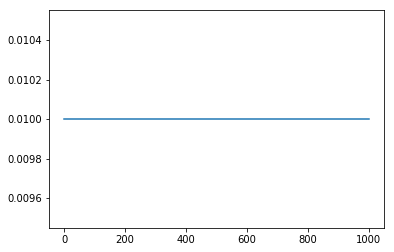

In [505]:
plt.plot(np.arange(sd.npoints)*sd.dx,sd.composition)